## Final Project Submission

Please fill out:
* Student name: Pedro Jofre Lora
* Student pace: self paced
* Scheduled project review date/time: 
* Instructor name: 
* Blog post URL:


# [Title of Paper]

## Introduction
This is the introduction where you explain the relevant information given the question that was asked. 

## Importing and cleaning data

In [1]:
import pandas as pd
import numpy as np
import warnings
warnings.simplefilter('ignore')

# Import the data
kc = pd.read_csv('kc_house_data.csv', index_col = 'id')
kc.columns = [col_name.title() for col_name in list(kc.columns)]
kc.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 21597 entries, 7129300520 to 1523300157
Data columns (total 20 columns):
Date             21597 non-null object
Price            21597 non-null float64
Bedrooms         21597 non-null int64
Bathrooms        21597 non-null float64
Sqft_Living      21597 non-null int64
Sqft_Lot         21597 non-null int64
Floors           21597 non-null float64
Waterfront       19221 non-null float64
View             21534 non-null float64
Condition        21597 non-null int64
Grade            21597 non-null int64
Sqft_Above       21597 non-null int64
Sqft_Basement    21597 non-null object
Yr_Built         21597 non-null int64
Yr_Renovated     17755 non-null float64
Zipcode          21597 non-null int64
Lat              21597 non-null float64
Long             21597 non-null float64
Sqft_Living15    21597 non-null int64
Sqft_Lot15       21597 non-null int64
dtypes: float64(8), int64(10), object(2)
memory usage: 3.5+ MB


In [2]:
pd.DataFrame(
    data = kc.nunique().sort_values(), 
    columns = ['Counts']
    ).transpose()

,Waterfront,Condition,View,Floors,Grade,Bedrooms,Bathrooms,Zipcode,Yr_Renovated,Yr_Built,Sqft_Basement,Date,Long,Sqft_Living15,Sqft_Above,Sqft_Living,Price,Lat,Sqft_Lot15,Sqft_Lot
Counts,2,5,5,6,11,12,29,70,70,116,304,372,751,777,942,1034,3622,5033,8682,9776


In [3]:
kc.describe()

,Price,Bedrooms,Bathrooms,Sqft_Living,Sqft_Lot,Floors,Waterfront,View,Condition,Grade,Sqft_Above,Yr_Built,Yr_Renovated,Zipcode,Lat,Long,Sqft_Living15,Sqft_Lot15
count,2.159700e+04,21597.000000,21597.000000,21597.000000,2.159700e+04,21597.000000,19221.000000,21534.000000,21597.000000,21597.000000,21597.000000,21597.000000,17755.000000,21597.000000,21597.000000,21597.000000,21597.000000,21597.000000
mean,5.402966e+05,3.373200,2.115826,2080.321850,1.509941e+04,1.494096,0.007596,0.233863,3.409825,7.657915,1788.596842,1970.999676,83.636778,98077.951845,47.560093,-122.213982,1986.620318,12758.283512
std,3.673681e+05,0.926299,0.768984,918.106125,4.141264e+04,0.539683,0.086825,0.765686,0.650546,1.173200,827.759761,29.375234,399.946414,53.513072,0.138552,0.140724,685.230472,27274.441950
min,7.800000e+04,1.000000,0.500000,370.000000,5.200000e+02,1.000000,0.000000,0.000000,1.000000,3.000000,370.000000,1900.000000,0.000000,98001.000000,47.155900,-122.519000,399.000000,651.000000
25%,3.220000e+05,3.000000,1.750000,1430.000000,5.040000e+03,1.000000,0.000000,0.000000,3.000000,7.000000,1190.000000,1951.000000,0.000000,98033.000000,47.471100,-122.328000,1490.000000,5100.000000
50%,4.500000e+05,3.000000,2.250000,1910.000000,7.618000e+03,1.500000,0.000000,0.000000,3.000000,7.000000,1560.000000,1975.000000,0.000000,98065.000000,47.571800,-122.231000,1840.000000,7620.000000
75%,6.450000e+05,4.000000,2.500000,2550.000000,1.068500e+04,2.000000,0.000000,0.000000,4.000000,8.000000,2210.000000,1997.000000,0.000000,98118.000000,47.678000,-122.125000,2360.000000,10083.000000
max,7.700000e+06,33.000000,8.000000,13540.000000,1.651359e+06,3.500000,1.000000,4.000000,5.000000,13.000000,9410.000000,2015.000000,2015.000000,98199.000000,47.777600,-121.315000,6210.000000,871200.000000


### Problems to Fix
1.  Date, View, and Sqft_basement are incorrect types.
2.  Waterfront and zipcode likely need to be converted to categorical.
3.  Condition and Grade might need to be converted to categorical, unless the numbers are a monotonic scale (scale of 1-5 with 5 being the "best").
4.  Investigate Yr_Renovated.
5.  Deciding what to do with the date.
6.  Deciding what to do with the lat and long values.

Data could be dropped from View, and it should also be converted to a binary category since the description is "has been viewed", and not "the number of times the propery has been viewed".

Waterfront and zipcode may not need to be converted to categorical and could be tossed out if the distributions of the groups is equal. If the distributions are not equal then they'll both be changed to categorical. It might be best to run separate analyses for the categories if there's enough data, since the relationships may change in shape given the value of a category.

Condition and Grade likely will not need to be converted to categorical, though we must assume that they are monotonic scales.

There is a surprisingly low mean and a very high std for Yr_Renovated, which may indicate that the data may not accurately represent what's going on. It may be the case that very few homes have renovations on file. If this is the case, then Yr_renovated should be changed to Renovated, which is a binary category indicating whether or not a renovation is on file.

The date will likely have a large impact on predicting the final sale price. I'll investigate to see if there is an impact, and then decide what to do.

Changing Lat and Long data into rectangular sectors can approximate neighborhoods that can then be used as categories. It would be best to look at a map of king county to see if there are distinct neighborhoods that could be drawn instead. This would be an interesting function...

### Some goals
-  The model should give a confidence interval for the price, instead of one value

### Resolving problems
1. Change Date and Sqft_Basement to correct types. Drop Data as necessary. Make a separate Basement as a category.

In [4]:
kc.Sqft_Basement.replace(to_replace = '?', 
                         value = np.nan, 
                         inplace = True)
kc.Sqft_Basement = kc.Sqft_Basement.apply(pd.to_numeric)
kc = kc[kc.Sqft_Basement.notnull()]
kc = kc[kc.View.notnull()]
kc.View = kc.View.where(kc.View <= 0, other = 1)
kc['View'] = (kc.View > 0).astype('category')

In [5]:
kc['Basement'] = (kc.Sqft_Basement>0).astype('category')

In [6]:
kc.Date = pd.to_datetime(kc.Date)

2. Change Waterfront and zipcode to categories if appropriate

In [7]:
waterfront_grouping = kc.groupby(by = 'Waterfront')
waterfront_grouping.groups.keys()

dict_keys([0.0, 1.0])

In [8]:
import seaborn as sns
import matplotlib.pyplot as plt
sns.set_style(style = 'dark')
ax1 = waterfront_grouping.get_group(0).Price.plot.hist(density = True)
waterfront_grouping.get_group(1).Price.plot.hist(density = True,
                                            secondary_y = True,
                                            alpha = 0.3,
                                            ax = ax1)
ax1.set_xlabel('Price');

The distributions are clearly different in shape, so waterfront will be converted to a category.

In [9]:
kc.Waterfront.fillna(0.0,inplace = True) # Assume that a null listing means the house is not waterfront
kc.Waterfront = (kc.Waterfront>0).astype('category')

In [10]:
del waterfront_grouping # Clean up workspace

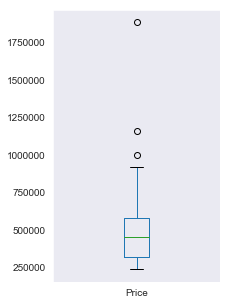

In [11]:
kc.groupby('Zipcode').Price.median().plot.box(figsize = (3,5));

The medians of the groups are too spread out to believe that zipcode might not have a significant impact on the final price of the house. It will be converted to a category.

In [12]:
kc.Zipcode = kc.Zipcode.astype('category')

3. Changing Grade and Condition to categories.

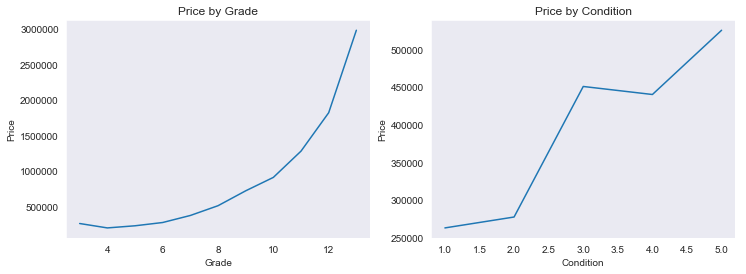

In [13]:
fig, (ax1, ax2) = plt.subplots(nrows = 1, ncols = 2, figsize = (12,4))
kc.groupby('Grade').Price.median().plot(ax = ax1, title = 'Price by Grade');
kc.groupby('Condition').Price.median().plot(ax = ax2, title = 'Price by Condition')
ax1.set_ylabel('Price')
ax2.set_ylabel('Price')
plt.show()

Price as a function of Grade is easily approximated by a simple function, so the data will remain numerical. Price as a function of Condition is not easily approximated by a simple function, so it will be converted to a category.

In [14]:
kc.Condition = kc.Condition.astype('category')

4.  Changing Yr_Renovated to Yrs_Since_Renovation is relatively straightforward. The complicated part is that many of the homes have a value of 0.0 for the year renovated, which is nonsensical. It would be good to investigate how many homes have a renovation date on record.

In [15]:
num_unknown_rennovations = kc.Yr_Renovated.replace(to_replace = 0,
                                                   value = np.nan).isna().sum()
num_renovated = (len(kc) - num_unknown_rennovations)
'The number of houses with documented renovations is {0:G}'.format(num_renovated)

'The number of houses with documented renovations is 722'

Since there are so few homes and so many features, I don't think it makes sense to treat this as a continuous variable for those homes that have been renovated.

In [16]:
kc.Yr_Renovated.fillna(0, inplace = True)
kc['Renovated'] = kc.Yr_Renovated.where(kc.Yr_Renovated <= 0, other = 1)
kc['Renovated'] = (kc.Renovated > 0).astype('category')
kc.drop(labels = 'Yr_Renovated', axis = 1, inplace = True)

5. Dealing with the date.

My inclination here is that prices are higher in the summer months because demand is higher. I'll look at a 30 day rolling window to spot trends in the median price, and also resample the data by month to also look for trends.

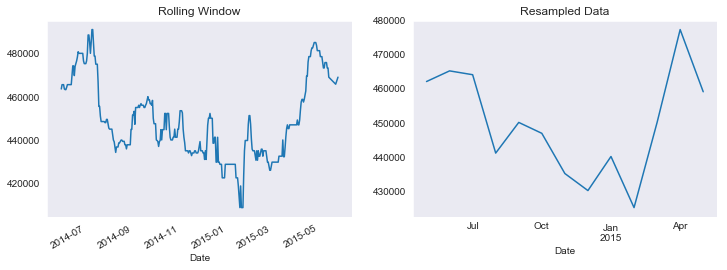

'The maximum swing in adjusted price is 11.61%'

In [17]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (12,4))
kc.groupby('Date').Price.median().rolling(30).median().plot(ax = ax1, title = 'Rolling Window')
kc.reset_index().set_index(['Date']).resample('m').Price.median().plot(ax = ax2, title = 'Resampled Data')
plt.show()

# Calculate the maximum 'swing' in price as compared to the median
price_adjustment = (kc.reset_index().set_index(['Date']).resample('m').Price.median() / kc.Price.median() - 1)*100
max_swing = price_adjustment.max()-price_adjustment.min()
'The maximum swing in adjusted price is {0:2.2f}%'.format(max_swing)

The maximum swing on the median price is a hefty 11.61%! The model will have to account for the time of the year in order to be more accurate. The easiest way to do this will be to resample by month and then turn into a category. Complexity can be added to the model later by fitting a function to the date, instead of simply categorizing by month.

In [18]:
kc['Month'] = kc.Date.dt.month_name().astype('category')
kc.drop('Date', axis = 1, inplace = True)

6. Deciding what to do with lat and long values

Here's a map of King County with zip-code boundaries:
<img src="https://www.kingcounty.gov/~/media/operations/GIS/maps/vmc/images/zipcodes_westKC_586.ashx?la=en" alt="An image of King County with zip-code boundaries" title="King Country Zip Codes" />
<br><br><br>
And, for comparison's sake, here's a map of Manhattan with zip-code boundaries:
<img src="https://www.propertyshark.com/Real-Estate-Reports/wp-content/uploads/2012/10/infographic-zip-codes-3.png" alt="An image of Manhattan with zip-code boundaries" title="Manhattan Zip Codes" />

Zip code boundaries trace a mixture of natural boundaries and, I suspect, socioeconomic boundaries. This is corroborated by the Manhattan zipcodes, where neighborhoods are roughly approximated by zip codes (I live in NYC, so I'm more familiar with the neighborhoods here). Though zip codes are not a perfect stand-in for neighborhoods, they are adequate for a first pass at this model. If I have time, I will attend to making discrete quadrants that better capture pricing at the neighborhood level. 


In [19]:
kc.drop(labels = ['Lat', 'Long'], axis = 1, inplace = True)

To finish up importing the data, I'll check the metadata again:

In [20]:
kc.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 21082 entries, 7129300520 to 1523300157
Data columns (total 19 columns):
Price            21082 non-null float64
Bedrooms         21082 non-null int64
Bathrooms        21082 non-null float64
Sqft_Living      21082 non-null int64
Sqft_Lot         21082 non-null int64
Floors           21082 non-null float64
Waterfront       21082 non-null category
View             21082 non-null category
Condition        21082 non-null category
Grade            21082 non-null int64
Sqft_Above       21082 non-null int64
Sqft_Basement    21082 non-null float64
Yr_Built         21082 non-null int64
Zipcode          21082 non-null category
Sqft_Living15    21082 non-null int64
Sqft_Lot15       21082 non-null int64
Basement         21082 non-null category
Renovated        21082 non-null category
Month            21082 non-null category
dtypes: category(7), float64(4), int64(8)
memory usage: 2.2 MB


That looks significantly better now. Some series' types could be changed to improve efficiency, but I'm not worried about it at this point since the dataframe is small.

## Exploring Data

First I'll look at violin plots of Price for the predictors that have categorical values. Then I'll look at distributions for continuous predictors. Before I go much further, I'll look for correlations between the continuous predictors and make some decisions about what data to drop. Finally, I'll look at scatter plots of Price vs continous predictors. In order to make this less repetitive, I'll use ipywidgets to create interactive displays. I'll dive deeper once this initial exploration is done.

In [21]:
import ipywidgets as widgets
from ipywidgets import interact, interact_manual

### 1.  Violin plots

In [22]:
hue_list = list(kc.select_dtypes('category').columns)
hue_list.append('None')

In [23]:
@interact
def violin_plot(x=list(kc.select_dtypes('category').columns), 
                yscale = ['log', 'linear'],
                hue = hue_list):
    
    fig, ax = plt.subplots(1,1,figsize = (12,8))
    if (hue != 'None') & (hue != x):
        title = "Price vs. " + x + " sorted by " + hue
        hue = kc[hue]
    else:
        hue = None
        title = "Price vs. " + x
    
    
    sns.violinplot(x = kc[x], 
                   y = kc.Price, 
                   cut = 0,
                   scale = 'area',
                   inner = 'box',
                   hue = hue,
                   ax = ax,
                   )
    plt.yscale(yscale)
    plt.title(title)


interactive(children=(Dropdown(description='x', options=('Waterfront', 'View', 'Condition', 'Zipcode', 'Baseme…

### 2.  Histograms of continuous variables

In [24]:
@interact
def hist_plot(data = list(kc.select_dtypes(include = [np.number]).columns),
             log_data = [True, False]):
    
    fig, ax = plt.subplots(1,1,figsize = (12,8))
    title = "Distribution of " + data
    
    if log_data:
        data = kc[data].replace(0,0.1)
        data = data.apply(np.log10)
    else:
        data = kc[data]
    sns.distplot(data,
                 ax = ax)
    plt.title(title)
    plt.show()

interactive(children=(Dropdown(description='data', options=('Price', 'Bedrooms', 'Bathrooms', 'Sqft_Living', '…

### 3.  Correlation matrix

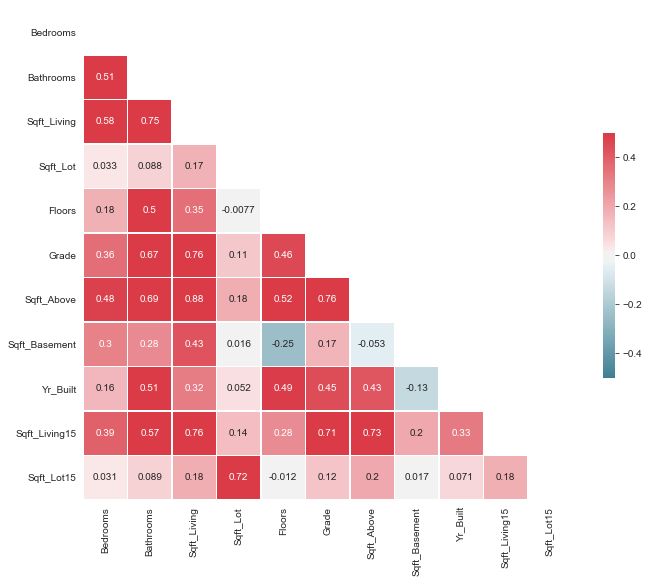

In [25]:
predictors = kc.drop(labels = 'Price', axis = 1)
sns.set_style('white')
corr = predictors.corr()
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True
f, ax = plt.subplots(figsize=(11, 9))
cmap = sns.diverging_palette(220, 10, as_cmap=True)
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.5, vmin = -0.5, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5}, annot = True)
plt.show()
sns.set_style()

The correlation matrix shows that many of these variables correlate with each other. I suppose I'm not surprised by this. After all, a more expensive house tends to have more bedrooms, bathrooms, space, and floors. Additionally, it is likely to have a higher grade and be newer. So, those things tend to go together and intuitively they will be correlated.

From the description of the columns, I don't think that we need to keep all three of: Sqft_living, Sqft_Above, and Sqft_Basement. Sqft_Above indicates the area of the house above the basement. It is likely that the sum of the area above the basement and the basement area is almost always the "living area". I'll check this assumption quickly. If this mostly holds true, then I'll drop "living area", if not then I'll drop "above".

In [26]:
print(((kc.Sqft_Above+kc.Sqft_Basement)==kc.Sqft_Living).sum()) #This is the number of houses whose area above and below matches total area
print(len(kc.Price))

21082
21082


How wonderful! It's a perfect match, so I'll drop Sqft_Living since it's accounted for in the sum of basement and above area.

In [27]:
kc.drop('Sqft_Living', axis = 1, inplace = True)

In [28]:
predictors.drop('Sqft_Living', axis = 1, inplace = True)

Now I'll look at predictors that measure the difference between the house itself and the houses of neighbors. The interesting thing to look at here, I think, is the houses that are NOT like their neighbors. I imagine that this is where differences arise, so it might be best to create new categories for these comparators that determines if the neighbors are bigger, smaller, or the same. To do this, I'll look at the differences between the house itself and its neighbors for each of these categories.

#### 3.1 Analyzing data of neighbors

In [29]:
neighbors_data = pd.DataFrame()
neighbors_data['Lot_Difference'] = (predictors.Sqft_Lot - predictors.Sqft_Lot15)/predictors.Sqft_Lot15
neighbors_data['Living_Difference'] = (predictors.Sqft_Above + predictors.Sqft_Basement - predictors.Sqft_Living15)/predictors.Sqft_Living15

In [30]:
neighbors_data.describe()

,Lot_Difference,Living_Difference
count,21082.000000,21082.000000
mean,0.134625,0.053131
std,1.293384,0.320548
min,-0.945028,-0.812721
25%,-0.063226,-0.118881
50%,0.000000,0.000000
75%,0.093809,0.161033
max,86.527179,5.000000


The descriptive data alone tells us that there are outliers in the data. I'll look at histograms to determine the cutoffs for outliers.

In [31]:
@interact
def lot_difference(
              low_lot = (-0.5,0,0.01),
              high_lot = (0,0.5,0.01),
              low_living = (-0.5,0,0.01),
              high_living = (0,0.5,0.01)):
    
    fig, (ax1, ax2) = plt.subplots(1,2,figsize = (16,9))
    
    title = "Distribution of Lot Difference"
    data = neighbors_data.Lot_Difference
    #lower_bound = data.quantile(low_lot)
    #upper_bound = data.quantile(high_lot)
    data = data[(data > low_lot) & (data < high_lot)]
    sns.distplot(data, ax = ax1)
    std_text = 'std: {:1.3f}'.format(data.std())
    ax1.text(0.5, 
             0.8, 
             std_text, 
             horizontalalignment='left',
             verticalalignment='top',
             fontsize = 16,
             transform=ax.transAxes)
    ax1.set_title('Scaled Lot Area Difference')
    
    title = "Distribution of Living Difference"
    data = neighbors_data.Living_Difference
    #lower_bound = data.quantile(low_living)
    #upper_bound = data.quantile(high_living)
    data = data[(data > low_living) & (data < high_living)]
    sns.distplot(data, ax = ax2)
    std_text = 'std: {:1.3f}'.format(data.std())
    ax2.text(1.5, 
             0.8, 
             std_text, 
             horizontalalignment='left',
             verticalalignment='top',
             fontsize = 16,
             transform=ax.transAxes)
    ax2.set_title('Scaled Living Area Difference')
    plt.show()

interactive(children=(FloatSlider(value=-0.25, description='low_lot', max=0.0, min=-0.5, step=0.01), FloatSlid…

The values center at 0, which makes sense because of the way that house lots and houses are constructed. Given this, it makes sense to define an intuitive value for which someone would pay more or less money. I'll assume that at ±10% of the size of the neighbors, the value of the house in question is likely to be significantly different than the the market vaulue of houses that are similar in size. That being said, I'll make categories that define houses that are above and below the regional value. Just to check my assumption, I'll look at the fraction of houses that are withing ±10% of 0 on the next line.

In [32]:
print(((neighbors_data.Living_Difference > -0.10) & (neighbors_data.Living_Difference < 0.10)).sum()/len(neighbors_data.Living_Difference)*100)
print(((neighbors_data.Lot_Difference > -0.10) & (neighbors_data.Lot_Difference < 0.10)).sum()/len(neighbors_data.Lot_Difference)*100)

40.94962527274452
55.61142206621763


±10% of a difference between sizes in living space and lot size account for 41% and 56% of the data, respectively. I think that enough of the data is represented in all the categories, and intuitively ±10% of a difference in size would likely make a difference for the average consumer. I'll make categories for the values that are above and below this cutoff.

In [33]:
neighbors_data['Living_Over10'] = (neighbors_data.Living_Difference > 0.10).astype('category')
neighbors_data['Living_Under10'] = (neighbors_data.Living_Difference < -.10).astype('category')
neighbors_data['Lot_Over10'] = (neighbors_data.Lot_Difference > 0.10).astype('category')
neighbors_data['Lot_Under10'] = (neighbors_data.Lot_Difference < -0.10).astype('category')

In [34]:
kc['Living_Over10'] = neighbors_data.Living_Over10
kc['Living_Under10'] = neighbors_data.Living_Under10
kc['Lot_Over10'] = neighbors_data.Lot_Over10
kc['Lot_Under10'] = neighbors_data.Lot_Under10
kc.drop(labels = ['Sqft_Living15', 'Sqft_Lot15'], axis = 1, inplace = True)

Now I'll look at those new categories to see if there is a marked difference.

In [35]:
@interact
def violin_plot(x=['Living_Under10', 'Living_Over10', 'Lot_Under10', 'Lot_Over10'], 
                yscale = ['log', 'linear'],
                hue = ['None', 'Living_Under10', 'Living_Over10', 'Lot_Under10', 'Lot_Over10']):
    
    fig, ax = plt.subplots(1,1,figsize = (12,8))
    if (hue != 'None') & (hue != x):
        title = "Price vs. " + x + " sorted by " + hue
        hue = kc[hue]
    else:
        hue = None
        title = "Price vs. " + x
    
    
    sns.violinplot(x = kc[x], 
                   y = kc.Price, 
                   cut = 0,
                   scale = 'area',
                   inner = 'box',
                   hue = hue,
                   ax = ax,
                   )
    plt.yscale(yscale)
    plt.title(title)

interactive(children=(Dropdown(description='x', options=('Living_Under10', 'Living_Over10', 'Lot_Under10', 'Lo…

It is clear that there is a difference in the price when looking at these factors together.

In [37]:
@interact
def scatter_plot(x = list(kc.select_dtypes(include = [np.number]).columns),
               log_x = [False, True],
               log_y = [False, True],
               hue = ['None', 'Waterfront', 'View', 'Basement', 'Renovated']):
    
    title = 'Price vs. ' + x
    fig, ax = plt.subplots(1,1,figsize = (12,8))
    if log_x:
        x = kc[x].replace(0,0.1)
        x = x.apply(np.log10)
    else:
        x = kc[x]
        
    if log_y:
        y = kc.Price.replace(0,0.1)
        y = y.apply(np.log10)
    else:
        y = kc.Price
        
    if (hue != 'None'):
        hue = kc[hue]
    else:
        hue = None
    
    sns.scatterplot(x = x, y = y, hue = hue, ax=ax)
    plt.title(title)
    plt.show()

interactive(children=(Dropdown(description='x', options=('Price', 'Bedrooms', 'Bathrooms', 'Sqft_Lot', 'Floors…

In [40]:
kc.corr().Price.sort_values(ascending = False)

Price            1.000000
Grade            0.668099
Sqft_Above       0.605481
Bathrooms        0.525029
Sqft_Basement    0.323018
Bedrooms         0.308454
Floors           0.256603
Sqft_Lot         0.088400
Yr_Built         0.054849
Name: Price, dtype: float64

Yr_Built and Sqft_Lot are not well correlated, so they will be dropped from the dataframe. Floors are also not well correlated and it is more highly correlated with Sqft_above, so that will be dropped too. The remaining continuous features can be sorted by RFE.

In [42]:
kc.drop(labels = ['Yr_Built', 'Sqft_Lot','Floors'], axis = 1, inplace = True)

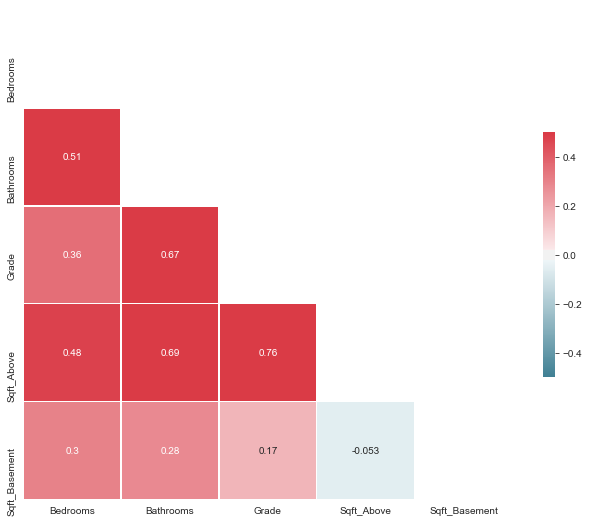

In [43]:
predictors = kc.drop(labels = 'Price', axis = 1)
sns.set_style('white')
corr = predictors.corr()
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True
f, ax = plt.subplots(figsize=(11, 9))
cmap = sns.diverging_palette(220, 10, as_cmap=True)
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.5, vmin = -0.5, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5}, annot = True)
plt.show()
sns.set_style()